# Embeddings and Vectors with Scikit-Bio

**Welcome to scikit-bio tutorial-02!** In this tutorial, we will showcase how the scikit-bio library can be utilized for embedding and vectorizing sets of protein sequences. Our goal is to demonstrate sequence classification and structural alignment using *TM-Vec* and *DeepBLAST* respectively.

### Introduction - a role of deep learning in `scikit-bio`
he application of deep learning in biology is gaining widespread popularity, with protein language models (pLMs) being a notable success story. By generating protein embeddings from sequence data, pLMs have paved the way for a range of innovative applications, including, for instance, fluorescent protein design by [ESM3](https://techcrunch.com/2024/06/25/evolutionaryscale-backed-by-amazon-and-nvidia-raises-142m-for-protein-generating-ai/) and [CRISPR-Cas design](https://www.biorxiv.org/content/10.1101/2024.04.22.590591v1).

Compared to traditional letter-encoded amino acids, protein embeddings offer a more expressive representation of a protein. In addition to sequence information, they encode structural, evolutionary (including organism of origin), and functional (such as thermostability and fluorescence) properties. These embeddings can be viewed as a compressed representation of multiple sequence alignments (MSAs), and thus, any task that benefits from MSA will also benefit from operations on embeddings. As computational optimizations of protein language models (pLMs) continue to emerge, embeddings-based methods are likely to gain popularity. Our goal is to provide an infrastructure that enables users to conduct sequence analysis leveraging embeddings.

However, not all tasks benefit from embeddings. The limitations of embeddings are discussed in detail in [Li et al., 2024](https://www.biorxiv.org/content/10.1101/2024.02.05.578959v2.abstract).

### What is TM-Vec? 
[TM-Vec](https://www.nature.com/articles/s41587-023-01917-2) is a tool that utilises protein representations from pLM in order to predict structural similarity of two proteins. 
### How does TM-Vec work? 
General protein representations (also called "embeddings"), that are predictive of protein structure, are obtained from pLM (ProtT5). Next, they are modified into vectors with the help of TM-Vec, which is another neural network. TM-Vec encodes proteins in a way that allows the cosine distance between two vectors to approximate structural similarity (measure via TM-score), thereby eliminating the need for time-consuming structure prediction.

In [ ]:
from importlib.util import find_spec
if find_spec('skbio') is None:
    !pip install -q scikit-bio

if find_spec('tmvec') is None:
    !pip install -q git+https://github.com/valentynbez/tmvec.git

if find_spec('deepblast') is None:
    !pip install -q deepblast

In [ ]:
import skbio
skbio.__version__

In [ ]:
# get data
!mkdir data
!wget -q -O ./data/bagel.tar.gz "https://www.dropbox.com/scl/fi/uytgo1cw8i65rnht0rzfx/bagel.tar.gz?rlkey=6smjeoy4p0r4b86a6h43ntkqb&dl=0"

In [ ]:
!tar zxf ./data/bagel.tar.gz

In [18]:
# All Necessary imports

from deepblast.dataset.utils import get_sequence, pack_sequences, revstate_f
from skbio.embedding import ProteinEmbedding, ProteinVector
from transformers import T5Tokenizer, T5EncoderModel
from skbio.alignment import PairAlignPath
from deepblast.utils import load_model
from skbio.sequence import Protein
import matplotlib.pyplot as plt
import skbio.embedding as emb
from skbio.io import read
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import re

### Helper Functions

In [19]:
# Helper Functions for Embedding Sequences
def load_protein_t5_embedding(sequence, model_name, tokenizer_name):

    tokenizer = T5Tokenizer.from_pretrained(tokenizer_name)
    model = T5EncoderModel.from_pretrained(model_name)

    # convert sequence to formatted list of strings
    seq_list = []
    seq_list.append(sequence)
    seqs = [" ".join(list(re.sub(r"[UZOB]", "X", str(seq)))) for seq in seq_list]

    # tokenize sequences and pad up to the longest sequence in the batch
    ids = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
    input_ids = torch.tensor(ids['input_ids'])
    attention_mask = torch.tensor(ids['attention_mask'])

    # generate embeddings
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)
    emb = embedding_repr.last_hidden_state[0, :-1, :].squeeze().detach().cpu().numpy()

    return ProteinEmbedding(emb, sequence)


def to_embeddings(sequences : list, model_name, tokenizer_name):
    # Embed the random/inputted protein sequence(s)
    for sequence in tqdm(sequences):
        test_embed = load_protein_t5_embedding(str(sequence), model_name, tokenizer_name)
        #reshape embeddings to fit the skbio format
        yield test_embed

In [20]:
# Load_vector function for vectors
def load_vectors(file_path, sequence_list : list):
      data = np.load(file_path)
      vectors = data['embeddings']

      protein_vectors = [ProteinVector(vector, sequence) for vector, sequence in zip(vectors, sequence_list)]
      return protein_vectors

In [21]:
# Structural Alignment Helper Functions
def condense_cigar(cigar_str):
    """
    Convert full length to condensed CIGAR
    Example: MMMIIII = 3M4I
    """
    condensed_cigar = ''
    current_state = ''
    count = 0
    for i in range(len(cigar_str)):
        if cigar_str[i] == current_state:
            count += 1
        else:
            if count > 0:
                condensed_cigar += str(count) + current_state
            current_state = cigar_str[i]
            count = 1
    condensed_cigar += str(count) + current_state
    return condensed_cigar


def tm_to_cigar(tm_alignment_string, condensed=False):
    """
    Convert TMalign style alignment string to CIGAR string
    """

    cigar = ''

    for state in tm_alignment_string:
        if state == ':':
            cigar += 'M'
        elif state == '1':
            cigar += 'I'
        elif state == '2':
            cigar += 'D'

    return cigar

def align(x, y, model):
    pred_alignment = model.align(str(x), str(y))
    # TODO : need to convert TMalign style string to cigar
    cigar = tm_to_cigar(pred_alignment)
    cigar = condense_cigar(cigar)
    path = PairAlignPath.from_cigar(cigar)
    return path


def predict_aln_matrix(query_seq, target_seq, model):
    x_code = get_sequence(str(query_seq), model.tokenizer)[0].to(model.device)
    y_code = get_sequence(str(target_seq), model.tokenizer)[0].to(model.device)
    seq, order = pack_sequences([x_code], [y_code])
    with torch.no_grad():
        gen = model.aligner.traceback(seq, order)
    _, aln_mat = next(gen)

    return aln_mat.squeeze()

### Part 1: Embedding sequences to file

We're going to start by reading in the bacteriocin sequences with `skbio.read`, then storing the embedded sequences in `ProteinEmbedding` objects.

In [22]:
model_name = "Rostlab/prot_t5_xl_uniref50"
tokenizer_name = "Rostlab/prot_t5_xl_uniref50"

# Parse bagel.fa
sequence_list = read("data/pdb_hits.fa", format='fasta')
embed_list = to_embeddings(sequence_list, model_name, tokenizer_name)

0it [23:00, ?it/s]


In [23]:
next(embed_list)

0it [00:00, ?it/s]

ProteinEmbedding
--------------------------------------------------------------------
Stats:
    length: 64
    embedding dimension: 1024
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
--------------------------------------------------------------------
0  MLYELVAYGI AQGTAEKVVS LINAGLTVGS IISILGGVTV GLSGVFTAVK AAIAKQGIKK
60 AIQL

### Part 2: Building vector-DB and plot Ordination

We can directly feed our FASTA file into the tmvec build_db __CLI__ function, which will output our 
vectors as a .npz file in the specified directory.

This function takes in as an input:
1. --input-fasta: A FASTA file containing your sequences.
2. --output: the file location to output to.

In [6]:
!tmvec build-db --input-fasta data/pdb_hits.fa --output outputs/pdb_hits_fasta

[2024-07-04 10:47:31] cli.build_db INFO: Removed 0 sequences longer than 1024 residues.
/home/pbatra6/GitHub/tm-vec/tmvec/vectorizer.py:107: UserWarning: Model not found locally. Loading from HuggingFace Hub.This will require an internet connection.
  warnings.warn(
Vectorizing sequences: 100%|████████████████████| 45/45 [00:03<00:00, 11.76it/s]
[2024-07-04 10:47:40] cli.build_db INFO: Please, do not move or rename input FASTA file, TM-Vec model and config files and ProtT5 model. They will be used to for sequence search. It is a design feature to ensure the consistency of the models used. If the location has chaged you can manually modify the database.


Now, with our DB in hand, we can use the search __CLI__ function to search for proteins against our database, and return the k-nearest neighbors results.  

In [7]:
!tmvec search --input-fasta data/pdb_hits.fa --database outputs/pdb_hits_fasta.npz --output results/pdb_hits_search_results --output-fmt skbio

[2024-07-04 10:47:46] cli.search INFO: Removed 0 sequences longer than 1024 residues.
/home/pbatra6/GitHub/tm-vec/tmvec/vectorizer.py:107: UserWarning: Model not found locally. Loading from HuggingFace Hub.This will require an internet connection.
  warnings.warn(
Vectorizing sequences: 100%|████████████████████| 45/45 [00:03<00:00, 11.64it/s]


#### Plot the ordination results

Finally, we can utilize the skbio embed_vec_to_ordination function to create ordination objects from our ProteinVector objects.

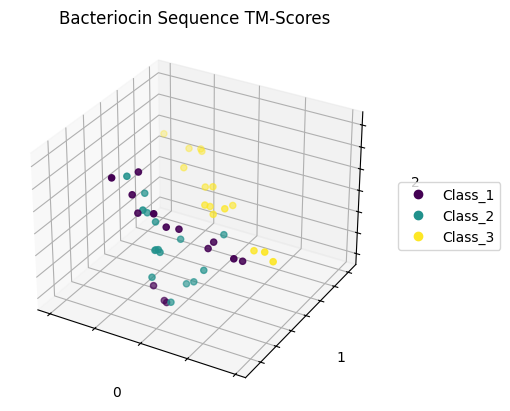

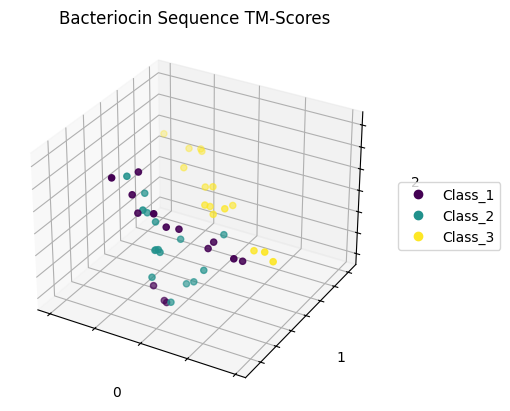

In [11]:
# load sequences
sequence_list = read("data/pdb_hits.fa", format='fasta')

#read in vectors to generator object
vec_generator = load_vectors("outputs/pdb_hits_fasta.npz", sequence_list)

ord_results = emb.embed_vec_to_ordination(vec_generator)

df = pd.read_csv("data/bagel_bacteriocins_all_classes.csv")
df = df.dropna(subset=['Sequence']).set_index('Sequence')
df = df.groupby('Sequence').first()

common_ids = list(set(ord_results.samples.index) & set(df.index))

df = df.loc[common_ids]
ord_results.samples = ord_results.samples.loc[common_ids]

# plot the results
ord_results.plot(df, column='class', title='Bacteriocin Sequence TM-Scores')

### Part 3: Structural Alignment with DeepBLAST

DeepBLAST is a deep learning tool that leverages protein embeddings to incorporate structural alignment information into sequence alignment. In essence, DeepBLAST has distilled information from thousands of observed protein structure alignments and integrated it into its alignment matrix. Consequently, DeepBLAST alignments can accurately match dissimilar amino acids based on structural information, making it the most accurate sequence-based method in the [Malidup and Malisam benchmarks](https://www.nature.com/articles/s41587-023-01917-2/tables/2). hile it falls short of structure alignment methods in terms of accuracy, DeepBLAST significantly reduces computational requirements, rendering the analysis of large datasets more feasible.  

In [ ]:
# download the model from scikit-bio HuggingFace repository!
!wget https://huggingface.co/scikit-bio/deepblast/resolve/main/deepblast-v3.ckpt -O ./data/deepblast-v3.ckpt

In [ ]:
# dropbox backup
# https://www.dropbox.com/scl/fi/gvbfgn7rnn4fqd2qq6fng/deepblast-v3.ckpt?rlkey=z7aig3kj1jjtt2q6qlu065afw&dl=0

In [ ]:
bagel_list = read("data/bagel.fa", format='fasta', constructor=Protein)

In [24]:
x = next(sequence_list)
y = next(sequence_list)

In [ ]:
model = load_model("./data/deepblast-v3.ckpt", device="cpu",
                   alignment_mode="smith-waterman"
                   )

path = align(x, y, model)

### Part 4: Visualization of Predicted Alignment Matrix

Probabilities and regions of alignment between two sequences can be visualized, thus enabling detailed analysis of conserved regions of proteins.

In [ ]:
matrix = predict_aln_matrix(x, y, model)

# visualise matrix with cbar
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.show();